In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, UpSampling2D, Add, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load VGG16 model outside of the loss function
vgg = tf.keras.applications.VGG16(include_top=False, input_shape=(64, 2048, 3))
vgg.trainable = False

def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (2, 2), strides=(2, 2), padding='same')(x)
    phi_g = Conv2D(inter_channel, (1, 1), padding='same')(g)
    concat_xg = Add()([theta_x, phi_g])
    act_xg = tf.keras.layers.Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tf.keras.layers.Activation('sigmoid')(psi)
    upsample_psi = UpSampling2D(size=(2, 2))(sigmoid_xg)
    attn_coefficients = multiply([upsample_psi, x])
    return attn_coefficients

# Define the U-Net model with attention for image-to-image translation
def attention_unet(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder with attention
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, attention_block(c4, c5, 512)])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, attention_block(c3, c6, 256)])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, attention_block(c2, c7, 128)])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, attention_block(c1, c8, 64)])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='tanh')(c9)

    return Model(inputs, outputs)

input_shape = (64, 2048, 1)
x = attention_unet(input_shape)
x.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 2048,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 2048,  │        640 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64, 2048,  │          0 │ conv2d_31[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 2048,  │     36,928 │ dropout_9[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 1024,  │          0 │ conv2d_32[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 1024,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 32, 1024,  │          0 │ conv2d_33[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 1024,  │    147,584 │ dropout_10[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 512,   │          0 │ conv2d_34[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 16, 512,   │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 16, 512,   │          0 │ conv2d_35[0][0]   │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 16, 512,   │    590,080 │ dropout_11[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 8, 256,    │          0 │ conv2d_36[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 8, 256,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 8, 256,    │          0 │ conv2d_37[0][0]   │
│ (Dropout)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 8, 256,    │  2,359,808 │ dropout_12[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 4, 128,    │          0 │ conv2d_38[0][0] 

 Total params: 33,122,437 (126.35 MB)

 Trainable params: 33,122,437 (126.35 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Loss functions
def perceptual_loss(y_true, y_pred):
    y_true_rgb = tf.image.grayscale_to_rgb(y_true)
    y_pred_rgb = tf.image.grayscale_to_rgb(y_pred)
    return tf.reduce_mean(tf.square(vgg(y_true_rgb) - vgg(y_pred_rgb)))

# Combine losses
def combined_loss(y_true, y_pred):
    l1_loss = MeanAbsoluteError()(y_true, y_pred)
    p_loss = perceptual_loss(y_true, y_pred)
    return l1_loss + p_loss

# Data loading and preprocessing
def load_data(comp_dir, lg_dir, image_size, batch_size):
    comp_images = []
    lg_images = []
    
    comp_files = sorted(os.listdir(comp_dir))
    lg_files = sorted(os.listdir(lg_dir))
    
    for comp_file, lg_file in zip(comp_files, lg_files):
        comp_path = os.path.join(comp_dir, comp_file)
        lg_path = os.path.join(lg_dir, lg_file)
        
        if os.path.isfile(comp_path) and os.path.isfile(lg_path):
            comp_img = load_img(comp_path, target_size=image_size, color_mode='grayscale')
            lg_img = load_img(lg_path, target_size=image_size, color_mode='grayscale')
            
            comp_img_array = img_to_array(comp_img)
            lg_img_array = img_to_array(lg_img)
            
            comp_images.append(comp_img_array)
            lg_images.append(lg_img_array)
    
    # Convert lists to arrays
    comp_images = np.array(comp_images)
    lg_images = np.array(lg_images)
    
    # Normalize images to [-1, 1]
    comp_images = comp_images / 127.5 - 1
    lg_images = lg_images / 127.5 - 1
    
    # Ensure the dataset size is divisible by the batch size
    num_samples = len(comp_images)
    remainder = num_samples % batch_size
    
    if remainder != 0:
        comp_images = comp_images[:-remainder]
        lg_images = lg_images[:-remainder]
    
    return comp_images, lg_images

# Define image size and batch size
image_size = (64, 2048)
batch_size = 1

# Load and preprocess data
comp_images, lg_images = load_data('/Selected_Comp', '/Selected_LG', image_size, batch_size)

# Create a TensorFlow dataset
train_data = tf.data.Dataset.from_tensor_slices((comp_images, lg_images))
train_data = train_data.batch(batch_size).shuffle(buffer_size=1000)

# Build and compile the model
input_shape = (64, 2048, 1)
model = attention_unet(input_shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=combined_loss)

In [ ]:
# Train the model
model.fit(train_data, epochs=50, batch_size=batch_size)

# Save the model
model.save('attention_unet_image_to_image.h5')

Epoch 1/50
 118/1000 ━━━━━━━━━━━━━━━━━━━━ 18:55 1s/step - loss: 0.4312

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


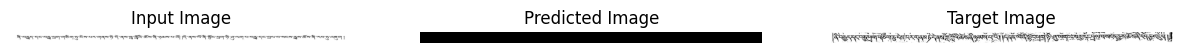

2024-07-13 07:34:41.300717: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
import random
import matplotlib.pyplot as plt

# Function to display images
def display_images(input_img, predicted_img, target_img=None):
    plt.figure(figsize=(15, 5))
    titles = ['Input Image', 'Predicted Image', 'Target Image']
    images = [input_img, predicted_img, target_img]
    
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        if images[i] is not None:
            img = images[i] if isinstance(images[i], np.ndarray) else images[i].numpy()
            plt.imshow(img.squeeze(), cmap='gray')
        else:
            plt.imshow(np.zeros_like(images[0].squeeze()), cmap='gray')
        plt.axis('off')
    plt.show()

# Pick a random image from the training data for inference
def infer_and_display_random(model, train_data):
    for input_imgs, target_imgs in train_data.take(1):
        idx = random.randint(0, input_imgs.shape[0] - 1)
        input_img = input_imgs[idx:idx+1]  # Select a single image
        target_img = target_imgs[idx]  # Corresponding target image

        # Predict the output image
        predicted_img = model.predict(input_img)

        # Display the input, predicted, and target images
        display_images(input_img[0], predicted_img[0], target_img)

# Example usage
infer_and_display_random(model, train_data)
